In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AdamW
import torch
from torch.utils.data import DataLoader, Dataset

In [5]:
from google.colab import files
uploaded = files.upload()

Saving MyData.csv to MyData.csv


In [6]:
import pandas as pd
data = pd.read_csv('MyData.csv')  # Replace with the exact filename if different
print(data.head())

        id                                       comment_text  funny  wow  \
0  1083994  He got his money... now he lies in wait till a...      0    0   
1   650904  Mad dog will surely put the liberals in mental...      0    0   
2  5902188  And Trump continues his lifelong cowardice by ...      1    0   
3  7084460  "while arresting a man for resisting arrest".\...      0    0   
4  5410943     Tucker and Paul are both total bad ass mofo's.      0    0   

   sad  likes  disagree  toxicity  severe_toxicity   obscene  ...  white  \
0    0      2         0  0.373134         0.044776  0.089552  ...    NaN   
1    1      2         0  0.605263         0.013158  0.065789  ...    NaN   
2    2      3         7  0.666667         0.015873  0.031746  ...    NaN   
3    0      0         0  0.815789         0.065789  0.552632  ...    NaN   
4    0      1         0  0.550000         0.037500  0.337500  ...    NaN   

   asian  latino  other_race_or_ethnicity  physical_disability  \
0    NaN     N

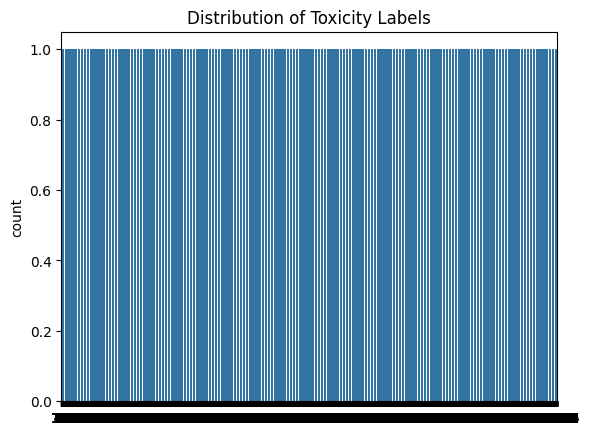

In [7]:
sns.countplot(data['toxicity'])
plt.title('Distribution of Toxicity Labels')
plt.show()

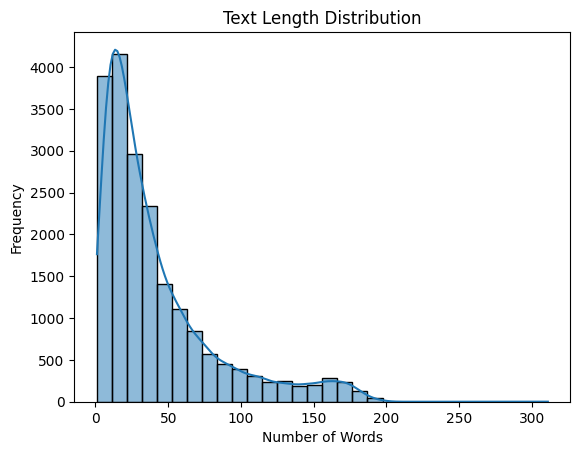

In [8]:
data['text_length'] = data['comment_text'].apply(lambda x: len(x.split()))
sns.histplot(data['text_length'], bins=30, kde=True)
plt.title('Text Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

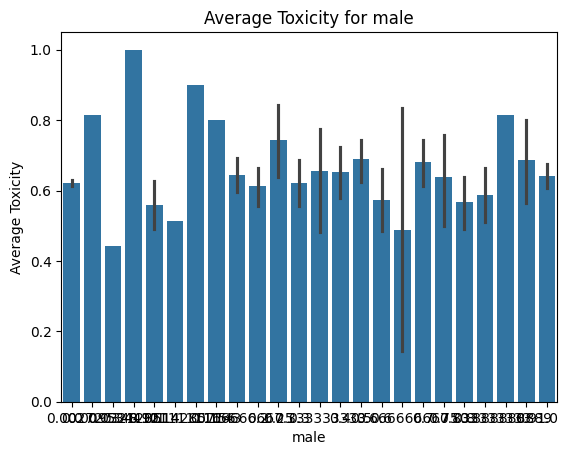

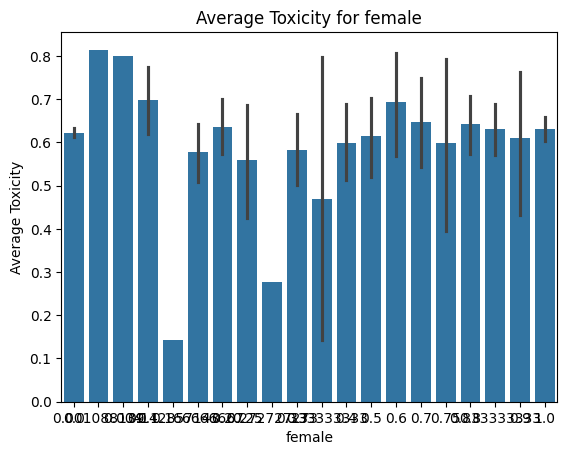

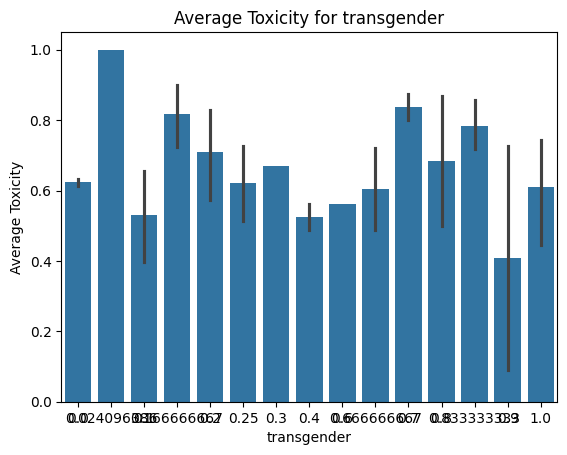

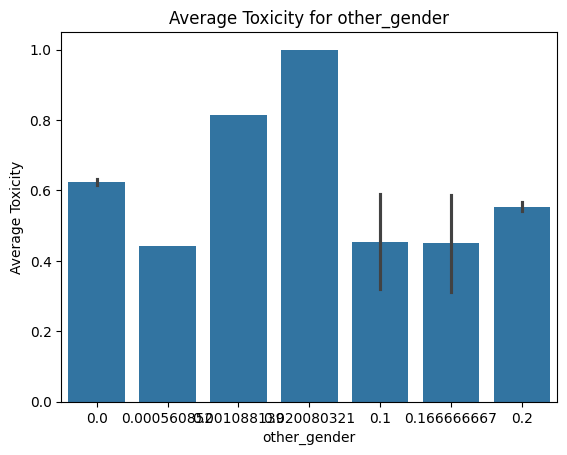

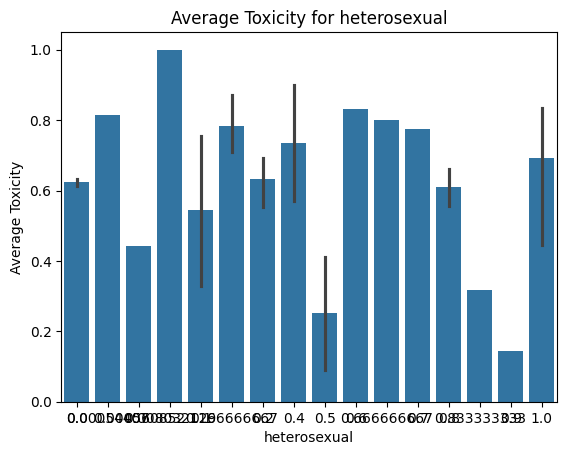

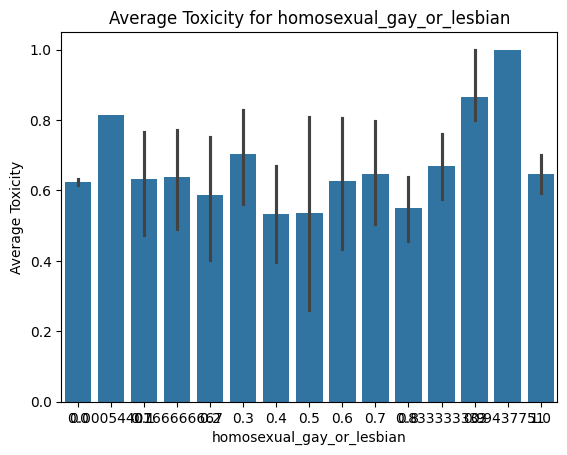

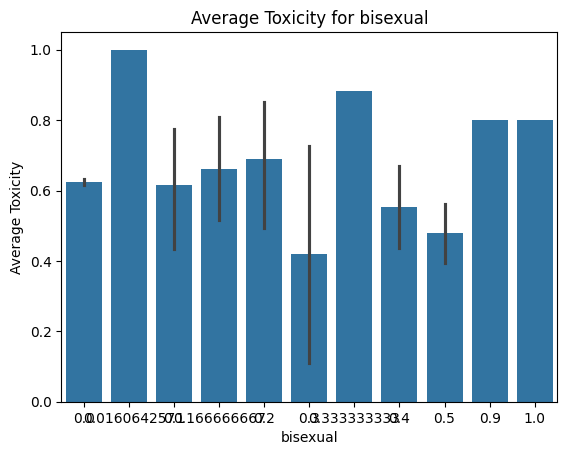

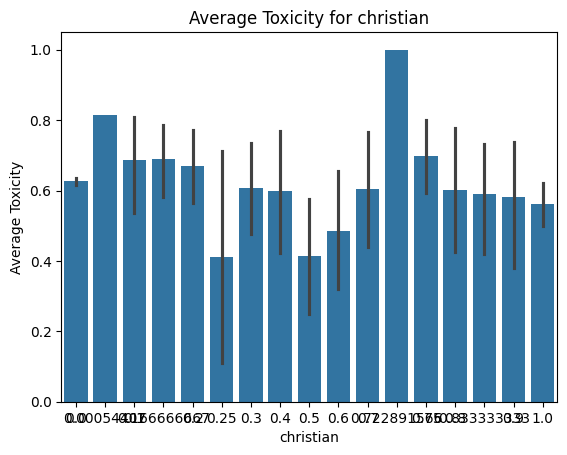

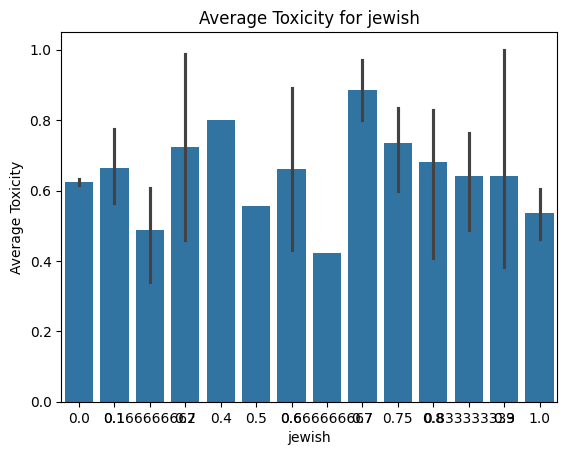

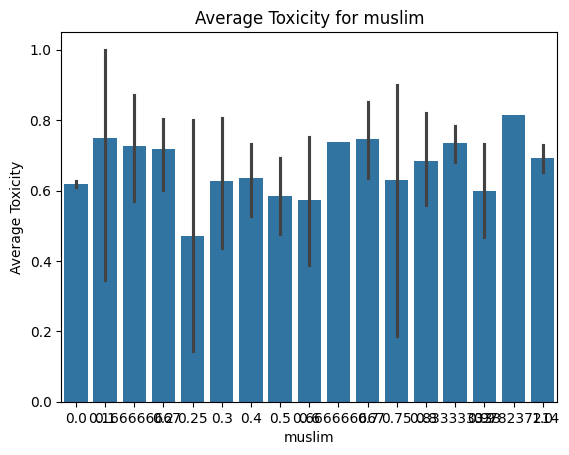

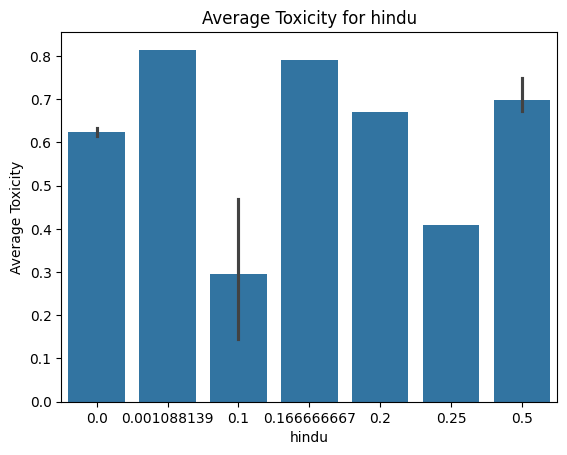

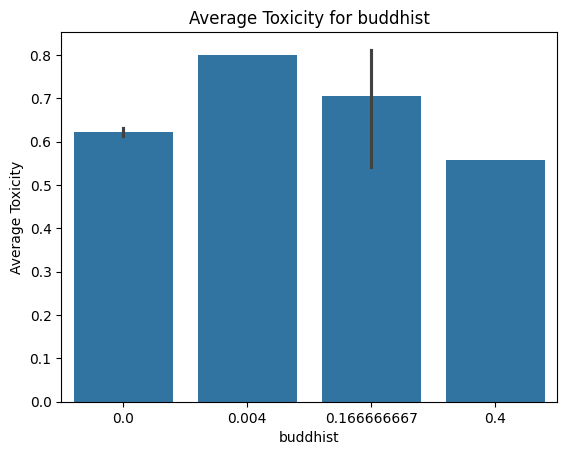

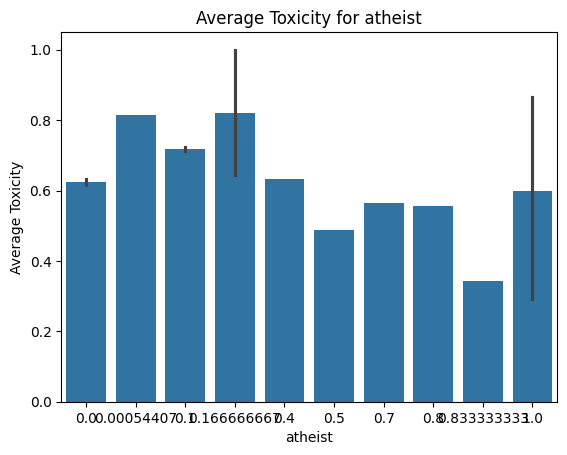

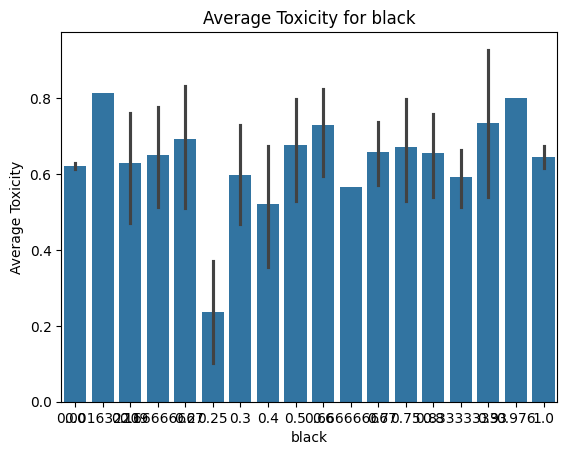

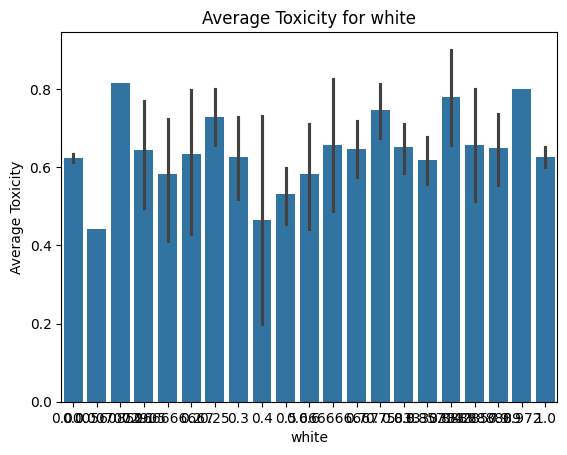

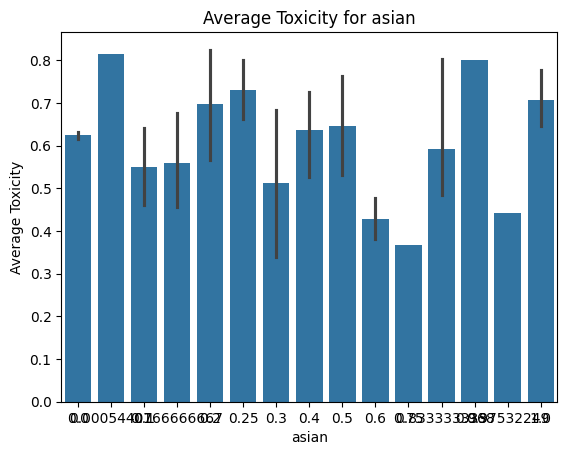

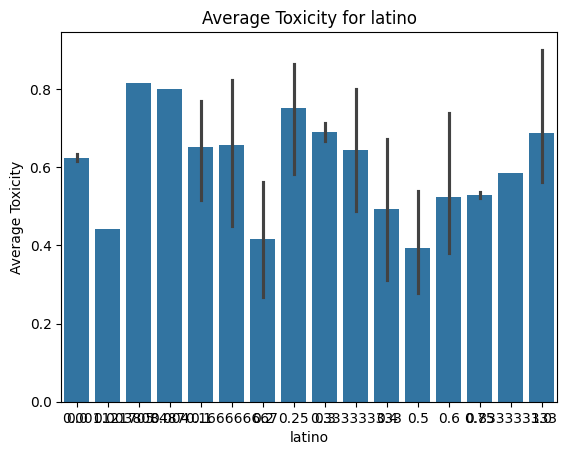

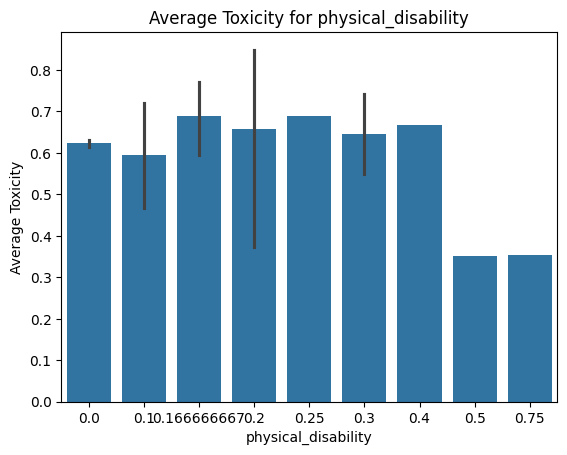

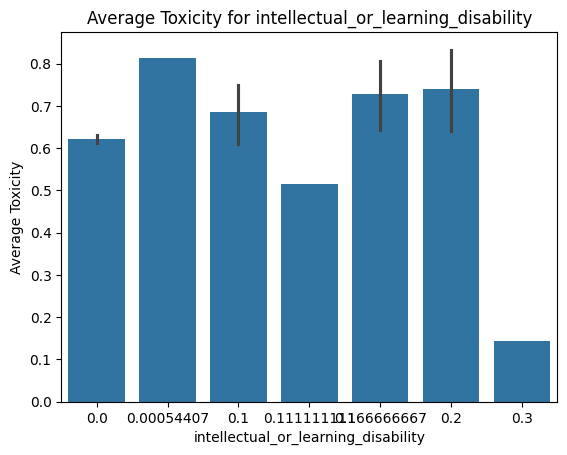

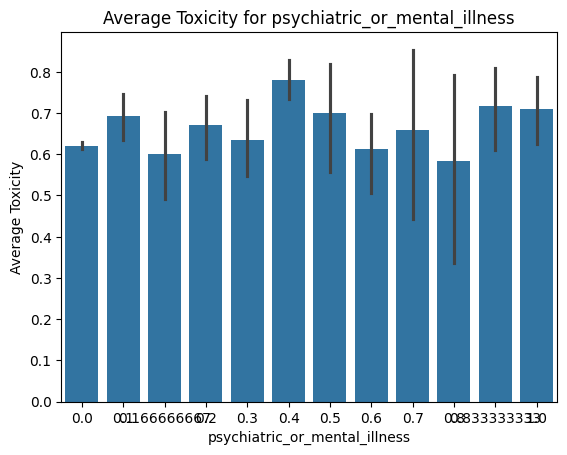

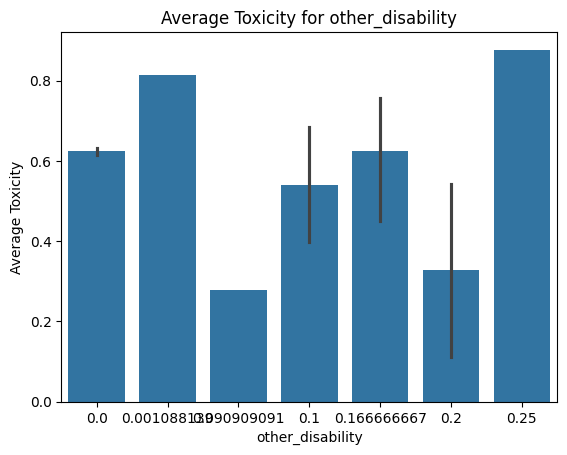

In [9]:
# List of sensitive attributes
identity_columns = [
    'male', 'female', 'transgender', 'other_gender', 'heterosexual',
    'homosexual_gay_or_lesbian', 'bisexual', 'christian', 'jewish', 'muslim',
    'hindu', 'buddhist', 'atheist', 'black', 'white', 'asian', 'latino',
    'physical_disability', 'intellectual_or_learning_disability',
    'psychiatric_or_mental_illness', 'other_disability'
]

# Plot average toxicity by identity
for col in identity_columns:
    if col in data.columns:
        sns.barplot(x=data[col], y=data['toxicity'])
        plt.title(f'Average Toxicity for {col}')
        plt.ylabel('Average Toxicity')
        plt.show()


In [12]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.4 MB/s eta 0:00:00


In [13]:
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error, classification_report
import matplotlib.pyplot as plt

In [27]:
X_raw = data['comment_text']
y = data['toxicity']  # Continuous target variable

# Preprocessing: Convert text data to numeric features
vectorizer = TfidfVectorizer(max_features=10000)
X = vectorizer.fit_transform(X_raw).toarray()

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
# Initialize CatBoostRegressor
catboost_regressor = CatBoostRegressor(
    iterations=500,  # Number of boosting rounds
    learning_rate=0.1,  # Learning rate
    depth=6,  # Depth of the tree
    loss_function='RMSE',  # Root Mean Square Error for regression
    verbose=50  # Print updates every 50 iterations
)

In [30]:
# Fit the regression model
catboost_regressor.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    verbose=50,
    early_stopping_rounds=50
)

0:	learn: 0.3525369	test: 0.3546990	best: 0.3546990 (0)	total: 394ms	remaining: 3m 16s
50:	learn: 0.2776332	test: 0.2828711	best: 0.2828711 (50)	total: 14.6s	remaining: 2m 8s
100:	learn: 0.2549985	test: 0.2630812	best: 0.2630812 (100)	total: 28.5s	remaining: 1m 52s
150:	learn: 0.2397724	test: 0.2502988	best: 0.2502988 (150)	total: 42.4s	remaining: 1m 38s
200:	learn: 0.2294881	test: 0.2425593	best: 0.2425593 (200)	total: 56.5s	remaining: 1m 24s
250:	learn: 0.2219698	test: 0.2376473	best: 0.2376473 (250)	total: 1m 10s	remaining: 1m 9s
300:	learn: 0.2157250	test: 0.2338482	best: 0.2338482 (300)	total: 1m 24s	remaining: 56.1s
350:	learn: 0.2106257	test: 0.2311205	best: 0.2311205 (350)	total: 1m 38s	remaining: 41.9s
400:	learn: 0.2059924	test: 0.2288957	best: 0.2288921 (399)	total: 1m 53s	remaining: 27.9s
450:	learn: 0.2020703	test: 0.2272004	best: 0.2272004 (450)	total: 2m 6s	remaining: 13.8s
499:	learn: 0.1983604	test: 0.2260300	best: 0.2260300 (499)	total: 2m 20s	remaining: 0us

bestTest

In [32]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = catboost_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared: {r2:.4f}")


Mean Squared Error: 0.0511
R-squared: 0.6087


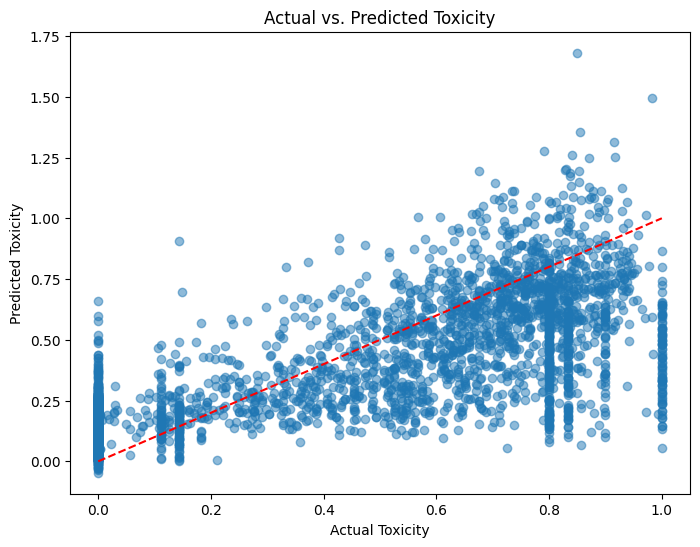

In [33]:
import matplotlib.pyplot as plt

# Plot actual vs. predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Line of perfect prediction
plt.xlabel('Actual Toxicity')
plt.ylabel('Predicted Toxicity')
plt.title('Actual vs. Predicted Toxicity')
plt.show()


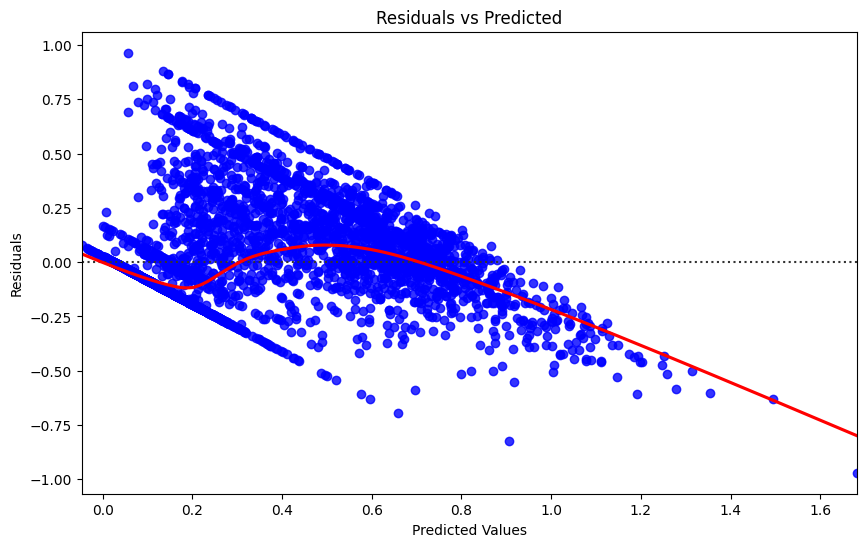

In [34]:
# Calculate residuals (errors)
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
sns.residplot(x=y_pred, y=residuals, lowess=True, color="blue", line_kws={'color': 'red'})
plt.title('Residuals vs Predicted')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()


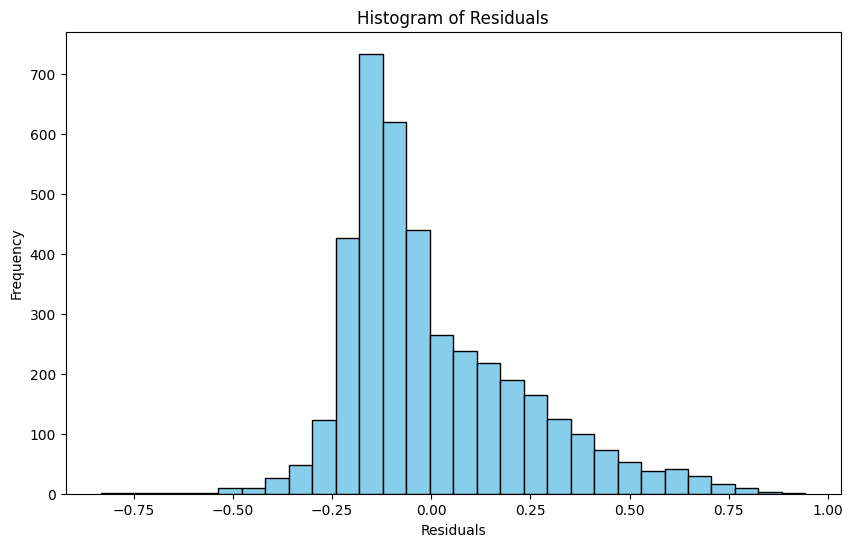

In [35]:
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

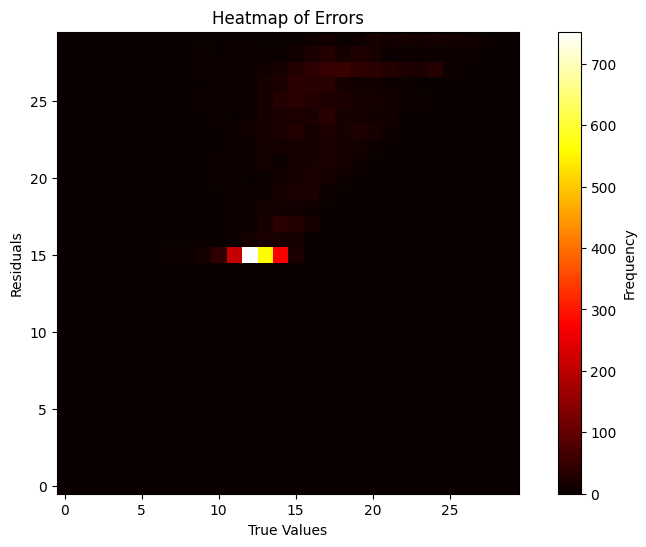

In [37]:
# Create a 2D histogram of errors over predicted value ranges
heatmap_data = np.histogram2d(y_test, residuals, bins=30, range=[[-1, 1], [-1, 1]])
plt.figure(figsize=(10, 6))
plt.imshow(heatmap_data[0], cmap='hot', interpolation='nearest', origin='lower')
plt.colorbar(label='Frequency')
plt.title('Heatmap of Errors')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.show()

